In [1]:
import sys
import os

# Obtém o diretório raiz do pacote
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adiciona o diretório raiz ao sys.path
sys.path.append(root_dir)

import lightning.pytorch as pl
from datamodule.chirps_cmip6 import ChirpsDataModule, ChirpsCmip6DataModule, Chirps, ChirpsCmip6
from model.swin2sr import Swin2SRLight
from model.swin2sr import Swin2SRLight
from model.vit import VisionTransfomerModule
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Swin2SRLight(upscale=5, img_size=(32, 32), in_chans=1,
                window_size=8, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')
model = model.load_from_checkpoint("/Users/dilermando/dev/downscaling/model/weights/swin2sr/version_11/checkpoints/epoch=99-step=21600.ckpt")

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
datamodule = ChirpsDataModule(data_dir="/Users/dilermando/dev/downscaling/datamodule/dataset/high-low")

trainer = pl.Trainer()
trainer.test(model, datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Testing DataLoader 0:   1%|▏         | 1/72 [00:02<02:50,  2.40s/it]

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing DataLoader 0: 100%|██████████| 72/72 [02:51<00:00,  2.39s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_mse_data       │   5.87396280025132e-05    │
│      test_mse_model       │  3.7895009882049635e-05   │
│      test_psnr_data       │    37.701622009277344     │
│      test_psnr_model      │    39.576393127441406     │
│      test_ssim_data       │     0.952022135257721     │
│      test_ssim_model      │    0.9607030153274536     │
└───────────────────────────┴───────────────────────────┘

[{'test_mse_model': 3.7895009882049635e-05,
  'test_psnr_model': 39.576393127441406,
  'test_ssim_model': 0.9607030153274536,
  'test_mse_data': 5.87396280025132e-05,
  'test_psnr_data': 37.701622009277344,
  'test_ssim_data': 0.952022135257721}]

In [4]:
data = Chirps(data_dir="../datamodule/dataset/high-low",
              transformations=False,
              type='eval')

In [17]:
data_cmip6 = ChirpsCmip6(data_dir="../datamodule/dataset/high-low",
                         transformations=False,
                         type='eval')

In [5]:
sr_images = []
model.eval()
model.to('cpu')
with torch.no_grad():
    for i in range(len(data)):
        image = data[i][0]
        image = image.unsqueeze(0)
        result = model(image.to('cpu'))
        result = result.to('cpu').numpy()
        result = result.squeeze(0).squeeze(0)               
        sr_images.append(result)
sr_images = np.array(sr_images)

In [6]:
sr_bilinear_images = []

for i in range(len(data)):
    image = data[i][0]
    image = image.unsqueeze(0)
    result = transforms.Resize((160, 160), antialias=True)(image)
    result = result.numpy()
    result = result.squeeze(0).squeeze(0)               
    sr_bilinear_images.append(result)

sr_bilinear_images = np.array(sr_bilinear_images)

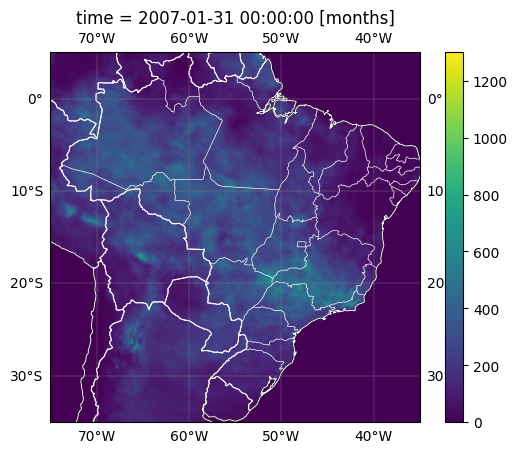

In [23]:
reconstruct = Chirps.reconstruct_image(data.chirps)
reconstruct_xr = Chirps.create_xarray(reconstruct)
Chirps.plot_map(reconstruct_xr*data.chirps_max, 0, vmax=1300)

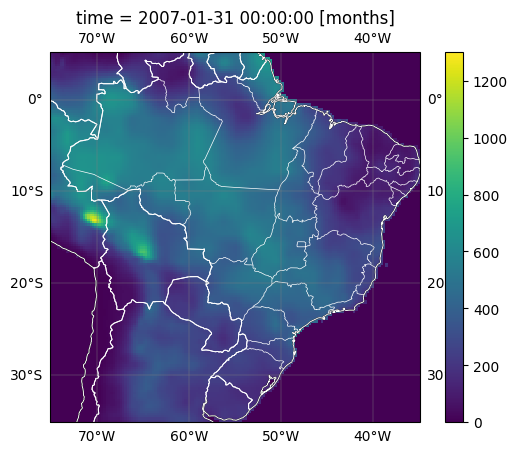

In [22]:
reconstruct = Chirps.reconstruct_image(data_cmip6.cmip6)
reconstruct_xr = Chirps.create_xarray(reconstruct)
Chirps.plot_map(reconstruct_xr*data.chirps_max, 0, vmax=1300)

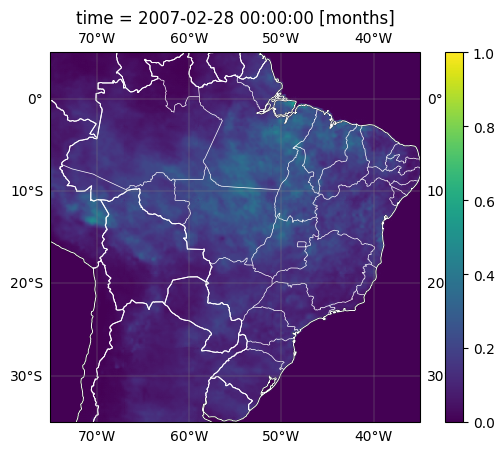

In [15]:
reconstruct = Chirps.reconstruct_image(np.maximum(sr_images, 0))
reconstruct_xr = Chirps.create_xarray(reconstruct)
Chirps.plot_map(reconstruct_xr, 1)

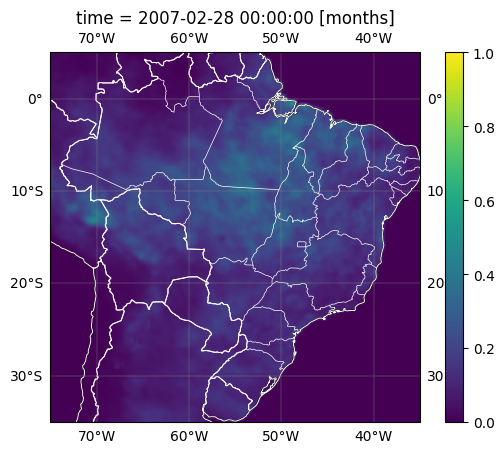

In [16]:
reconstruct = Chirps.reconstruct_image(np.maximum(sr_bilinear_images, 0))
reconstruct_xr = Chirps.create_xarray(reconstruct)
Chirps.plot_map(reconstruct_xr, 1)

Text(0.5, 1.0, 'CHIRPS')

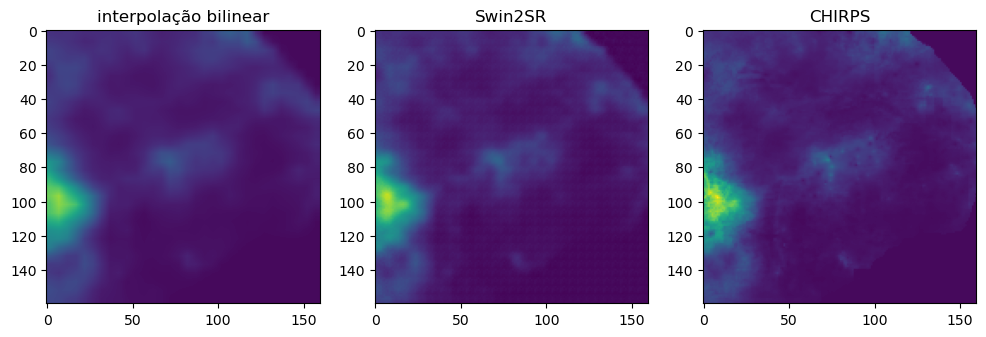

In [6]:
import random
from datamodule.chirps_cmip6 import Chirps, ChirpsCmip6

dataset = Chirps(data_dir="/dccstor/weathergenerator/users/dilermando/downscaling/datamodule/dataset/high-low", type='test',
                  transformations=False)

# inference model
model.eval()

i = random.randint(0, len(dataset))

output = model(dataset[i][0].unsqueeze(0))

vmin = min(dataset[i][0][0].min(), output[0][0].to("cpu").detach().numpy().min(), dataset[i][1][0].min())
vmax = max(dataset[i][0][0].max(), output[0][0].to("cpu").detach().numpy().max(), dataset[i][1][0].max())

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 8))


ax0.imshow(transforms.Resize((160, 160), antialias=True)(dataset[i][0])[0], vmin=vmin, vmax=vmax)
ax0.set_title(f'interpolação bilinear')

ax1.imshow(output[0][0].to("cpu").detach().numpy(), vmin=vmin, vmax=vmax)
ax1.set_title(f'Swin2SR')

ax2.imshow(dataset[i][1][0], vmin=vmin, vmax=vmax)
ax2.set_title('CHIRPS')


# Bias

In [2]:
model = VisionTransfomerModule(img_size=(32,32), in_channels=1, out_channels=1, history=1)
model = model.load_from_checkpoint("/Users/dilermando/dev/downscaling/model/weights/vit-bias/version_1/checkpoints/epoch=99-step=21600.ckpt")

In [12]:
datamodule = ChirpsCmip6DataModule(data_dir="../datamodule/dataset/high-low")

trainer = pl.Trainer()
trainer.test(model, datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


AttributeError: 'ChirpsCmip6DataModule' object has no attribute 'prepare_data_per_node'

In [4]:
data = ChirpsCmip6(data_dir="/Users/dilermando/dev/downscaling/datamodule/dataset/high-low",
              transformations=False,
              type='eval')

In [6]:
model = model.to('cpu')
bias_images = []
model.eval()
with torch.no_grad():
    for i in range(len(data)):
        image = data[i][0]
        image = image.unsqueeze(0)
        result = model(image.to('cpu'))
        result = result.to('cpu').numpy()
        result = result.squeeze(0).squeeze(0)               
        bias_images.append(result)
bias_images = np.array(bias_images)

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
chirps = []
for i in range(len(data)):
    chirps.append(data[i][1].squeeze(0).numpy())

chirps = np.array(chirps)

In [15]:
np.max([reconstruct_chirps[i].max(), reconstruct_model[i].max(), reconstruct_cmip6[i].max()])

0.8713774496797537

In [13]:
i = 34
reconstruct_chirps = Chirps.reconstruct_image(chirps)
reconstruct_chirps_xr = Chirps.create_xarray(reconstruct_chirps)

reconstruct_model = Chirps.reconstruct_image(np.maximum(bias_images, 0))
reconstruct_model_xr = Chirps.create_xarray(reconstruct_model)

reconstruct_cmip6 = Chirps.reconstruct_image(data.cmip6)
reconstruct_cmip6_xr = Chirps.create_xarray(reconstruct_cmip6)

vmax = np.max([reconstruct_chirps[i].max(), reconstruct_model[i].max(), reconstruct_cmip6[i].max()])

Chirps.plot_map(reconstruct_model_xr, i, vmax=vmax)
Chirps.plot_map(reconstruct_chirps_xr, i, vmax=vmax)
Chirps.plot_map(reconstruct_cmip6_xr, i, vmax=vmax)

error_cmip6 = np.abs(reconstruct_chirps - reconstruct_cmip6)
error_model = np.abs(reconstruct_chirps - reconstruct_model)
error_cmip6_model = error_cmip6 - error_model

error_cmip6_xr = Chirps.create_xarray(error_cmip6)
error_model_xr = Chirps.create_xarray(error_model)
error_cmip6_model_xr = Chirps.create_xarray(error_cmip6_model)

vmax_error = np.max([error_cmip6[i].max(), error_model[i].max()])
Chirps.plot_map(error_cmip6_xr, i, cmap='Reds', vmax=vmax_error)
Chirps.plot_map(error_model_xr, i, cmap='Reds', vmax=vmax_error)
Chirps.plot_map(error_cmip6_model_xr, i, vmin=-0.5, vmax=0.5, cmap='bwr')


TypeError: plot_map() got an unexpected keyword argument 'vmax'

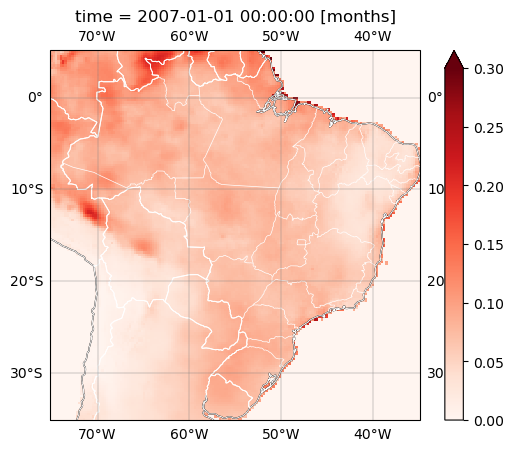

In [59]:
Chirps.plot_map(
    error_cmip6_xr.resample(time='96MS').mean(dim='time'),
    0,
    vmax=0.3,
    cmap='Reds'
)

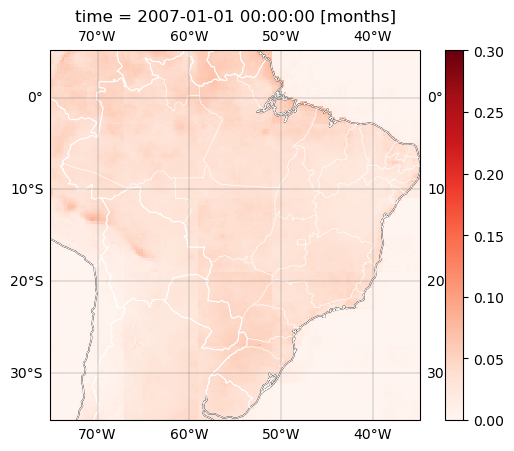

In [60]:
Chirps.plot_map(
    error_model_xr.resample(time='96MS').mean(dim='time'),
    0,
    vmin=0,
    vmax=0.3,
    cmap='Reds'
)

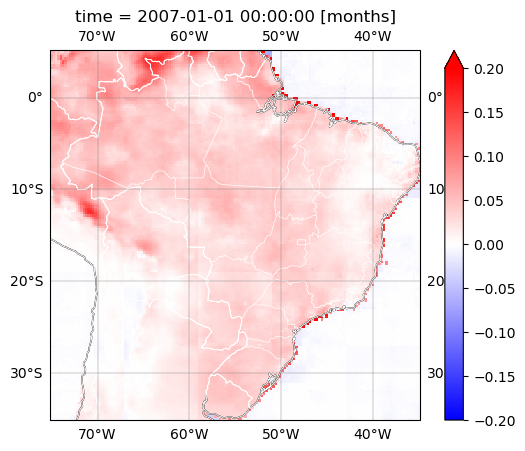

In [61]:
Chirps.plot_map(
    error_cmip6_model_xr.resample(time='96MS').mean(dim='time'),
    0,
    vmin=-0.2,
    vmax=0.2,
    cmap='bwr'
)

Text(0.5, 1.0, 'CHIRPS')

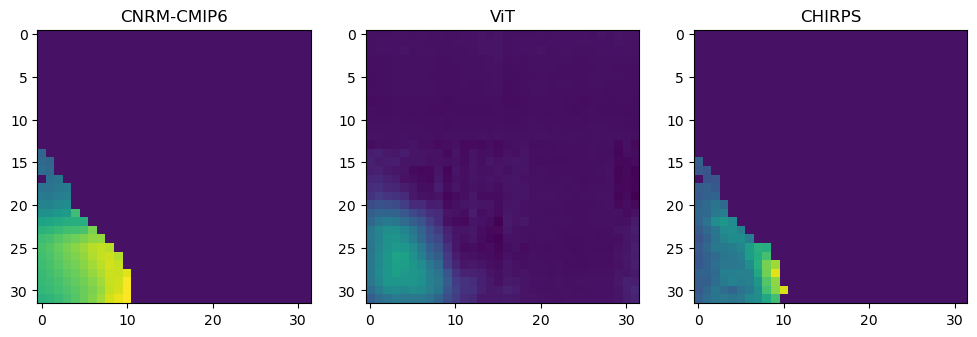

In [23]:
import random
from datamodule.chirps_cmip6 import Chirps, ChirpsCmip6

dataset = ChirpsCmip6(data_dir="/dccstor/weathergenerator/users/dilermando/downscaling/datamodule/dataset/high-low",
                        type='test',
                        transformations=False)

# inference model
model.eval()

i = random.randint(0, len(dataset))

output = model(dataset[i][0].unsqueeze(0))

vmin = min(dataset[i][0][0].min(), output[0][0].to("cpu").detach().numpy().min(), dataset[i][1][0].min())
vmax = max(dataset[i][0][0].max(), output[0][0].to("cpu").detach().numpy().max(), dataset[i][1][0].max())

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 8))


ax0.imshow(dataset[i][0][0], vmin=vmin, vmax=vmax)
ax0.set_title(f'CNRM-CMIP6')
# ax0.set_ylim(ax0.get_ylim()[::-1])

ax1.imshow(output[0][0].to("cpu").detach().numpy(), vmin=vmin, vmax=vmax)
ax1.set_title(f'ViT')
# ax1.set_ylim(ax1.get_ylim()[::-1])

ax2.imshow(dataset[i][1][0], vmin=vmin, vmax=vmax)
ax2.set_title('CHIRPS')
# ax2.set_ylim(ax2.get_ylim()[::-1])
